In [ ]:
#author: Michael Yao
#last updated: 30 November 2024
#this notebook solves a numerical example of the model in "Historical Emissions, Growth, and Who Should Abate"

import numpy as np
import pandas as pd
import scipy
from math import sqrt, log
import matplotlib.pyplot as plt

In [ ]:
#set params
delta = 0.1 #0.05
rho = 1

In [25]:
#define functions

def F(K, AL):
    if K < 0:
        return 0
    else:
        return AL * K ** 0.5

def F_prime(K, AL):
    if K < 0:
        return 0
    else:
        return AL * 1/(2*(K**0.5))

def C(phi):
    #return phi ** -1
    return 1 * np.exp(-0.2 * phi)

def C_prime(phi):
    #return - (phi ** -2)
    return -0.2 * np.exp(-0.2 * phi)

def new_K(K, s):
    return K + s * F(K) - delta * K

# multiple countries numerical optimization #

In [ ]:
n_countries = 2
E = 6000 #emissions cap

In [ ]:
# utilities of consumption
def utilities(guess, K, AL, n):
    """takes in vector of guesses [s1, phi1, s2, phi2,...]
    a vector of capital [K1, K2, ...], and the number of countries
    and sums utilities"""

    u = np.zeros(n)

    #loop over production of every country
    for i in range(n):
        s_i = guess[2*i] 
        phi_i = guess[2*i + 1]
        K_i = K[i]
        AL_i = AL[i]
        
        F1 = F(K_i, AL_i)
        K_tplus1 = K_i + s_i * F1 - delta * K_i
        F2 = F(K_tplus1, AL_i)

        #plug production into utility function
        u_i = rho * log(max(F2, 0.0001)) + log(max( (1-s_i) * F1 - C(phi_i), 0.0001))

        u[i] = u_i

    #sum the utilities, negate since we're using the scipy minimizer
    return -1 * np.sum(u)


# emissions constraint
def e_constraint(guess):
    """takes in vector of guesses [s1, phi1, s2, phi2,...] and outputs emissions"""
    
    emissions = np.zeros(n_countries)

    #loop over production of every country
    for i in range(n_countries):
        s_i = guess[2*i] 
        phi_i = guess[2*i + 1]
        K_i = K_arg[i]
        AL_i = AL_arg[i]
        
        F1 = F(K_i, AL_i)
        K_tplus1 = K_i + s_i * F1 - delta * K_i
        F2 = F(K_tplus1, AL_i)

        #calculate emissions of each country
        emissions_i = phi_i * (F2 + F1)

        emissions[i] = emissions_i

    return np.sum(emissions)

In [ ]:
# constrain 0 <= s <= 1, and phi >= 0
from scipy.optimize import Bounds

bounds = Bounds([0, 0, 0, 0], [1.0, np.inf, 1.0, np.inf])

In [ ]:
# global carbon budget constraint
from scipy.optimize import NonlinearConstraint

cons_e = NonlinearConstraint(e_constraint, 0, E)

In [ ]:
# name the columns of the output dataframe

s_phi = []
for i in range(n_countries):
    s_phi = s_phi + [f's{i+1}', f'phi{i+1}']

capitals = []
for i in range(n_countries):
    capitals = capitals + [f'K_{i+1}t', f'K_{i+1}tplus1']

prod_labour = [f'AL{i+1}' for i in range(n_countries)]

costs = [f'C{i+1}' for i in range(n_countries)]

products = []
for i in range(n_countries):
    products = products + [f'F_K_{i+1}t', f'F_K_{i+1}tplus1']

emissions = [f'e{i+1}' for i in range(n_countries)]
for i in range(n_countries):
    emissions = emissions + [f'e{i+1}t', f'e{i+1}tplus1']

optimum_vars = s_phi + capitals + prod_labour + costs + products + [f'cons_{i+1}t' for i in range(n_countries)] + emissions 

In [ ]:
max_K = 100 #both countries' starting capital sum to max_K
runs = 20

#set up the dataframe for results
optimum_df = pd.DataFrame(np.zeros((runs, len(optimum_vars))), columns = optimum_vars)

#set up scenarios
optimum_df['K_1t'] = np.linspace(10, 51, runs)
optimum_df['K_2t'] = max_K - optimum_df['K_1t']

optimum_df['AL1'] = 25
optimum_df['AL2'] = 25

In [ ]:
#initial value for constrained minimizer
init_val = [0.3, 10, 0, 5]

for i in range(runs): #i indexes the scenario
    K_arg = optimum_df[['K_1t', 'K_2t']].iloc[i, :].to_numpy()
    AL_arg = optimum_df[['AL1', 'AL2']].iloc[i, :].to_numpy()

    choices = scipy.optimize.minimize(utilities, init_val, args = (K_arg, AL_arg, 2), method='trust-constr', 
                constraints=[cons_e], bounds=bounds, options = {'maxiter' : 1600})
    
    optimum_df.iloc[i, :(2*n_countries)] = choices.x 

    init_val = choices.x #use this scenario's solution as the next scenario's starting value

    #calculate capital, production, consumption, and emissions from choices of s and phi
    for j in range(n_countries): #j indexes the country
        optimum_df.loc[i, f'C{j+1}'] = C(optimum_df.loc[i, f's{j+1}'])
        optimum_df.loc[i, f'F_K_{j+1}t'] = F(optimum_df.loc[i, f'K_{j+1}t'], optimum_df.loc[i, f'AL{j+1}'])
        optimum_df.loc[i, f'e{j+1}t'] = optimum_df.loc[i, f'phi{j+1}'] * optimum_df.loc[i, f'F_K_{j+1}t']
        optimum_df.loc[i, f'cons_{j+1}t'] = [(1- optimum_df.loc[i, f's{j+1}']) * optimum_df.loc[i, f'F_K_{j+1}t']]

        optimum_df.loc[i, f'K_{j+1}tplus1'] = (optimum_df.loc[i, f'K_{j+1}t'] +  
                                               optimum_df.loc[i, f's{j+1}'] * optimum_df.loc[i, f'F_K_{j+1}t']
                                               - delta * optimum_df.loc[i, f'K_{j+1}t'])
        optimum_df.loc[i, f'F_K_{j+1}tplus1'] = F(optimum_df.loc[i, f'K_{j+1}tplus1'], optimum_df.loc[i, f'AL{j+1}'])
        optimum_df.loc[i, f'e{j+1}tplus1'] = optimum_df.loc[i, f'phi{j+1}'] * optimum_df.loc[i, f'F_K_{j+1}tplus1']

        optimum_df.loc[i, f'e{j+1}'] = optimum_df.loc[i, f'e{j+1}t'] + optimum_df.loc[i, f'e{j+1}tplus1']  

optimum_df.head()

c:\Users\Xbrai\miniforge3\envs\scarf\lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
c:\Users\Xbrai\miniforge3\envs\scarf\lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
c:\Users\Xbrai\miniforge3\envs\scarf\lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero i

,s1,phi1,s2,phi2,K_1t,K_1tplus1,K_2t,K_2tplus1,AL1,AL2,...,F_K_2t,F_K_2tplus1,cons_1t,cons_2t,e1,e2,e1t,e1tplus1,e2t,e2tplus1
0,0.256907,15.844420,0.104890,5.264460,10.000000,29.310254,90.000000,105.876931,25,25,...,237.170825,257.241292,58.746687,212.293893,3397.111758,2602.812781,1252.611347,2144.500411,1248.576306,1354.236476
1,0.249093,14.860397,0.107627,5.272864,12.157895,32.655680,87.842105,104.276006,25,25,...,234.310298,255.289059,65.456857,209.092187,3418.386167,2581.590988,1295.387210,2122.998957,1235.486413,1346.104575
2,0.241946,14.006556,0.110404,5.324042,14.315789,35.770035,85.684211,102.664751,25,25,...,231.414415,253.309039,71.704705,205.865454,3419.149783,2580.688165,1324.887566,2094.262218,1232.060130,1348.628035
3,0.235327,13.312797,0.113212,5.374358,16.473684,38.704780,83.526316,101.040614,25,25,...,228.481832,251.297402,77.591002,202.614901,3421.420450,2578.505386,1350.842380,2070.578071,1227.943172,1350.562214
4,0.229122,12.674364,0.116064,5.457786,18.631579,41.493177,81.368421,99.405227,25,25,...,225.511115,249.255425,83.186026,199.337467,3408.754608,2591.174341,1367.700501,2041.054107,1230.791486,1360.382855


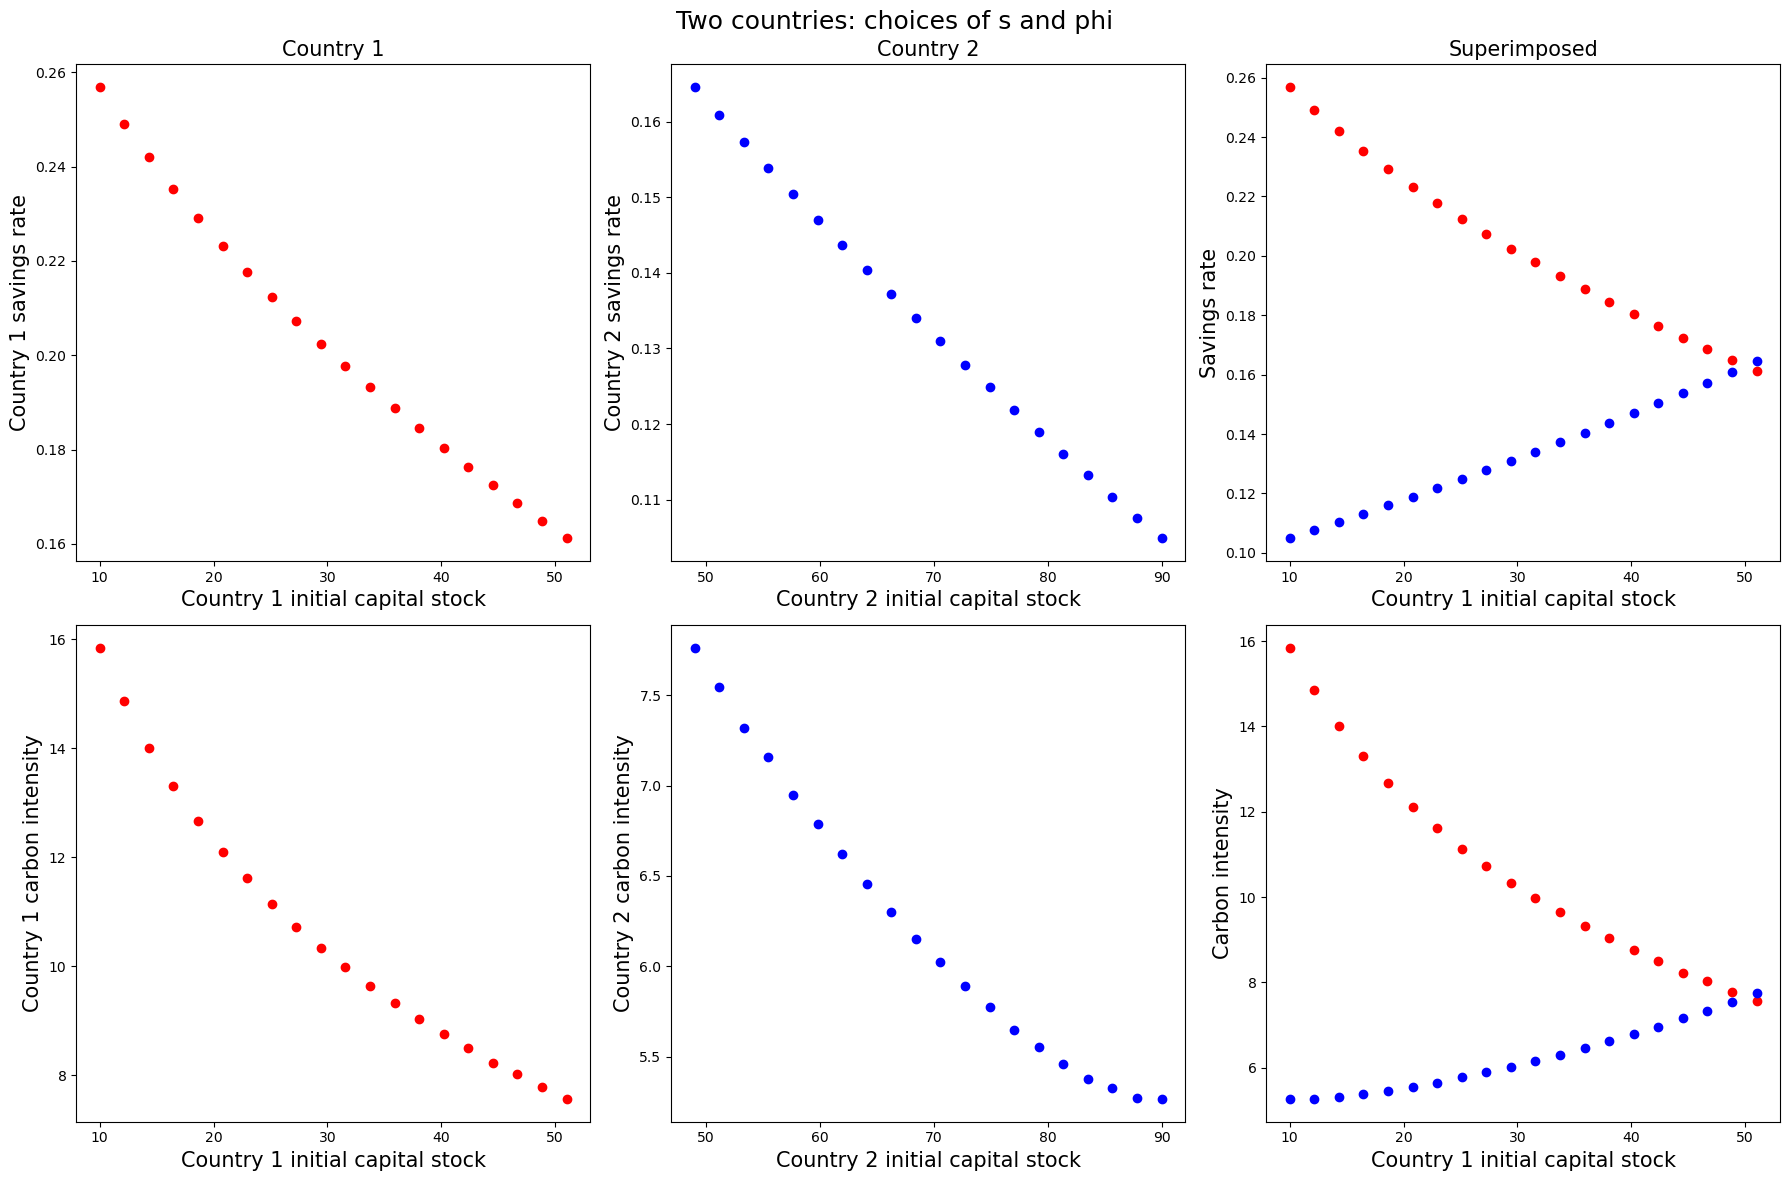

In [ ]:
#plot choices of s and phi
fig, ax = plt.subplots(2, 3, figsize = (18, 12))

colors = cm.plasma(np.linspace(0, 0.8, runs))

ax[0, 0].scatter(optimum_df['K_1t'], optimum_df['s1'], color = 'red')
ax[0, 0].set_xlabel('Country 1 initial capital stock', fontsize = 15)
ax[0, 0].set_ylabel('Country 1 savings rate', fontsize = 15)
# ax[0, 0].set_ylim((-1.3, 0.5))
ax[0, 0].set_title('Country 1', fontsize = 15)

ax[0, 1].scatter(optimum_df['K_2t'], optimum_df['s2'], color = 'blue')
ax[0, 1].set_xlabel('Country 2 initial capital stock', fontsize = 15)
ax[0, 1].set_ylabel('Country 2 savings rate', fontsize = 15)
# ax[0, 1].set_ylim((-1.3, 0.5))
ax[0, 1].set_title('Country 2', fontsize = 15)

ax[1, 0].scatter(optimum_df['K_1t'], optimum_df['phi1'], color = 'red')
ax[1, 0].set_xlabel('Country 1 initial capital stock', fontsize = 15)
ax[1, 0].set_ylabel('Country 1 carbon intensity', fontsize = 15)
# ax[1, 0].set_ylim((40, 60))

ax[1, 1].scatter(optimum_df['K_2t'], optimum_df['phi2'], color = 'blue')
ax[1, 1].set_xlabel('Country 2 initial capital stock', fontsize = 15)
ax[1, 1].set_ylabel('Country 2 carbon intensity', fontsize = 15)
# ax[1, 1].set_ylim((40, 60))

ax[0, 2].scatter(optimum_df['K_1t'], optimum_df['s1'], color = 'red')
ax[0, 2].scatter(optimum_df['K_1t'], optimum_df['s2'], color = 'blue')
ax[0, 2].set_xlabel('Country 1 initial capital stock', fontsize = 15)
ax[0, 2].set_ylabel('Savings rate', fontsize = 15)
# ax[0, 2].set_ylim((-1.3, 0.5))
ax[0, 2].set_title('Superimposed', fontsize = 15)

ax[1, 2].scatter(optimum_df['K_1t'], optimum_df['phi1'], color = 'red')
ax[1, 2].scatter(optimum_df['K_1t'], optimum_df['phi2'], color = 'blue')
ax[1, 2].set_xlabel('Country 1 initial capital stock', fontsize = 15)
ax[1, 2].set_ylabel('Carbon intensity', fontsize = 15)
# ax[1, 2].set_ylim((40, 60))

plt.suptitle('Two countries: choices of s and phi', fontsize = 18)
plt.tight_layout()

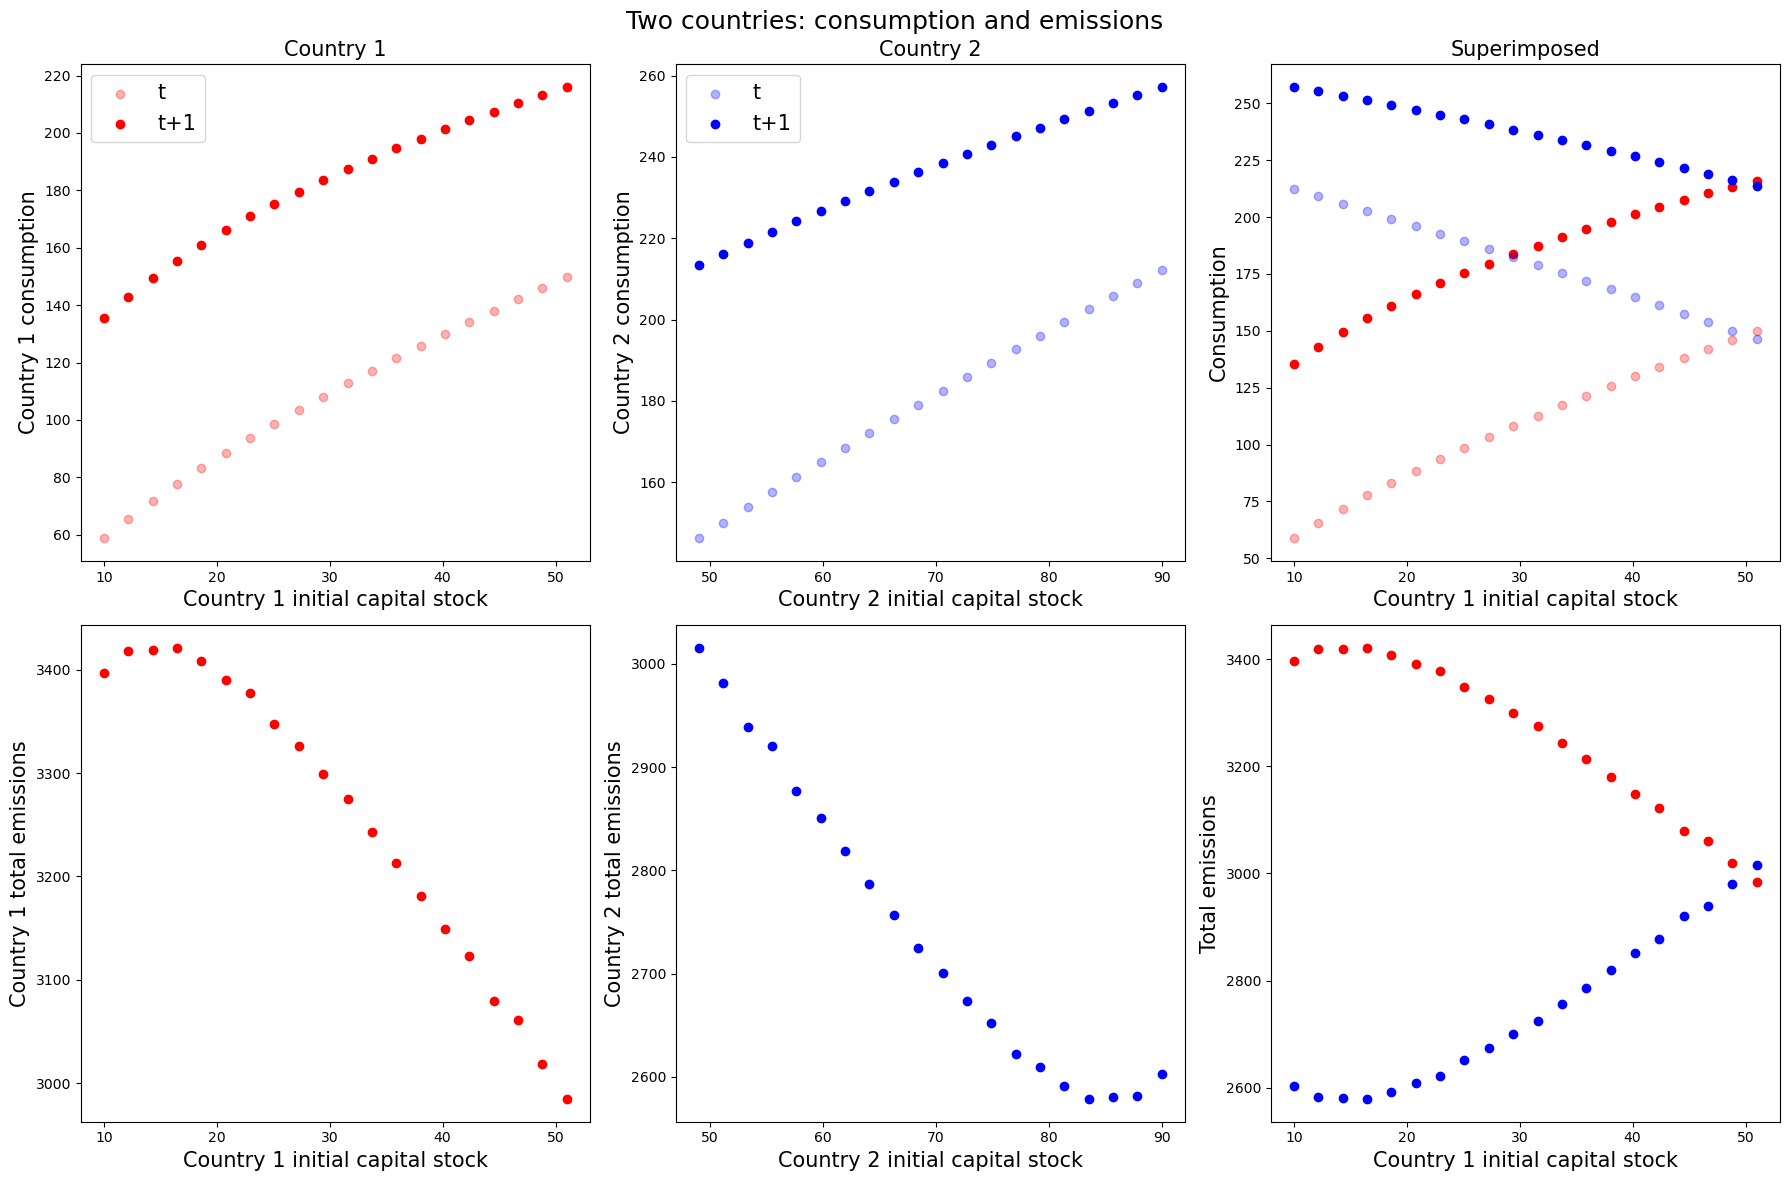

In [ ]:
#plot consumption and emission
fig, ax = plt.subplots(2, 3, figsize = (18, 12))

colors = cm.plasma(np.linspace(0, 0.8, runs))

ax[0, 0].scatter(optimum_df['K_1t'], optimum_df['cons_1t'], color = 'red', alpha = 0.3, label = 't')
ax[0, 0].scatter(optimum_df['K_1t'], optimum_df['F_K_1tplus1'], color = 'red', label = 't+1')
ax[0, 0].set_xlabel('Country 1 initial capital stock', fontsize = 15)
ax[0, 0].set_ylabel('Country 1 consumption', fontsize = 15)
# ax[0, 0].set_ylim((-1.3, 0.5))
ax[0, 0].set_title('Country 1', fontsize = 15)
ax[0, 0].legend(fontsize = 15)

ax[0, 1].scatter(optimum_df['K_2t'], optimum_df['cons_2t'], color = 'blue', alpha = 0.3, label = 't')
ax[0, 1].scatter(optimum_df['K_2t'], optimum_df['F_K_2tplus1'], color = 'blue', label = 't+1')
ax[0, 1].set_xlabel('Country 2 initial capital stock', fontsize = 15)
ax[0, 1].set_ylabel('Country 2 consumption', fontsize = 15)
# ax[0, 1].set_ylim((-1.3, 0.5))
ax[0, 1].set_title('Country 2', fontsize = 15)
ax[0, 1].legend(fontsize = 15)

ax[1, 0].scatter(optimum_df['K_1t'], optimum_df['e1'], color = 'red')
ax[1, 0].set_xlabel('Country 1 initial capital stock', fontsize = 15)
ax[1, 0].set_ylabel('Country 1 total emissions', fontsize = 15)
# ax[1, 0].set_ylim((40, 60))

ax[1, 1].scatter(optimum_df['K_2t'], optimum_df['e2'], color = 'blue')
ax[1, 1].set_xlabel('Country 2 initial capital stock', fontsize = 15)
ax[1, 1].set_ylabel('Country 2 total emissions', fontsize = 15)
# ax[1, 1].set_ylim((40, 60))

ax[0, 2].scatter(optimum_df['K_1t'], optimum_df['cons_1t'], color = 'red', alpha = 0.3)
ax[0, 2].scatter(optimum_df['K_1t'], optimum_df['F_K_1tplus1'], color = 'red')
ax[0, 2].scatter(optimum_df['K_1t'], optimum_df['cons_2t'], color = 'blue', alpha = 0.3)
ax[0, 2].scatter(optimum_df['K_1t'], optimum_df['F_K_2tplus1'], color = 'blue')
ax[0, 2].set_xlabel('Country 1 initial capital stock', fontsize = 15)
ax[0, 2].set_ylabel('Consumption', fontsize = 15)
# ax[0, 2].set_ylim((-1.3, 0.5))
ax[0, 2].set_title('Superimposed', fontsize = 15)

ax[1, 2].scatter(optimum_df['K_1t'], optimum_df['e1'], color = 'red')
ax[1, 2].scatter(optimum_df['K_1t'], optimum_df['e2'], color = 'blue')
ax[1, 2].set_xlabel('Country 1 initial capital stock', fontsize = 15)
ax[1, 2].set_ylabel('Total emissions', fontsize = 15)
# ax[1, 2].set_ylim((40, 60))

plt.suptitle('Two countries: consumption and emissions', fontsize = 18)
plt.tight_layout()